<a href="https://colab.research.google.com/github/zemerov/hate_detection/blob/main/hate_speach_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter hate speach detection

General plan:
1. Finetune RoBERTa or DeBERTa
2. Construct PR-curve
3. Compare to plain inference
4. Make simle CLI for inference


In [1]:
%%capture
!pip install transformers
!pip install datasets

import torch 
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import copy
import os
from tqdm import tqdm
from tqdm import notebook

import datasets 

sns.set(palette='summer')

## Dataset and dataloaders

In [2]:
class CustomIterator:
    def __init__(self, dataset, tokenizer: RobertaTokenizer, batch_size: int = 64):
        """
        :param dataset: dataset with smaples and labels
        """
        # Sort dataset for reduce padding idx in training
        self.dataset = sorted(
            dataset, 
            key=lambda x: len(x[1])
            ) 

        self.batches = []

        for i in notebook.tqdm_notebook(range(0, len(self.dataset), batch_size), desc="Batching data"):
            self.batches.append(
                (
                    tokenizer(
                        [x[1] for x in self.dataset[i:min(i + batch_size, len(dataset))]],
                        return_tensors='pt',
                        padding=True,
                        truncation=True
                    ),
                    torch.LongTensor(
                        [x[0] for x in self.dataset[i:min(i + batch_size, len(dataset))]]
                                              )
                )
            )
    
    def __iter__(self):
        """
        Batch generator
        yield batch: ({"input_ids" : toch.Tensor, "attention_mask": torch.Tensor}, target: torch.LongTensor)
        """
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

In [3]:
dataset = datasets.load_dataset('tweets_hate_speech_detection', split='train')

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (/root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c32a982d8b2d6233065d820ac655454174f8aaa8faddc74979cf793486acd3b0)


In [4]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

The dataset is imbalanced, so that add class weights in loss to get appropriate results.

In [5]:
class_weights = torch.FloatTensor([1, (len(dataset) - sum(dataset['label'])) / sum(dataset['label']) ])
class_weights

tensor([ 1.0000, 13.2560])

In [6]:
text_label = []

for x in dataset:
    text_label.append((x['label'], x['tweet']))

In [7]:
train_set, test_set = train_test_split(text_label, shuffle=True, test_size=0.2)
valid_set, test_set = train_test_split(test_set, shuffle=True, test_size=0.5)

print("Got sizes for train {}; valid {}; test {}.".format(len(train_set), len(valid_set), len(test_set)))

Got sizes for train 25569; valid 3196; test 3197.


In [8]:
BATCH_SIZE = 40

train_iterator = CustomIterator(train_set, tokenizer, BATCH_SIZE)
valid_iterator = CustomIterator(valid_set, tokenizer, BATCH_SIZE)
test_iterator = CustomIterator(test_set, tokenizer, BATCH_SIZE)

## Download pretrained Roberta model

In [9]:
device = 'cuda'
model = RobertaForSequenceClassification.from_pretrained('roberta-base').to(device)

In [10]:
optimizer = AdamW(model.parameters())

## Training loop

In [11]:
def calculate_classification_metrics(pred, real):
    """
    Calculates binary classification metrics: accuracy, precision, recall, f1.

    :param pred, real: np.array with same shape. 
    :return (accuracy, precision, recall, f1): tuple of floats 
    """
    tp = (pred[real == 1] == 1).sum()
    fp = (pred[real == 0] == 1).sum()
    fn = (pred[real == 1] == 0).sum()

    accuracy = (pred == real).sum() / real.shape[0]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

In [12]:
def save_checkpoint(save_path, model):    
    torch.save(model.state_dict(), save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(torch.load(load_path, map_location=device))

In [13]:
def evaluate(eval_iter, model, criterion=nn.NLLLoss(), show=False):
    """
    Evaluate model on eval_iter
    :param eval_iter: torch.Iterator
    :param model: torch.nn.Module. Model to evaluate 
    :param criterion: torch loss function.
    :param show: bool. Whether to print accuracy, precision etc scores.
      
    :return (valid_running_loss, (accuracy, precision, recall, f1_score)): all floats
    """
    model.eval()

    predicted = torch.LongTensor([0])
    real = torch.LongTensor([0])
    valid_running_loss = []
    with torch.no_grad():
        for batch in eval_iter:
            x, y = batch
            
            input = x['input_ids'].to(device)
            attention_mask = x['attention_mask'].to(device)
            labels = y.to(device)

            logits = model(input, attention_mask=attention_mask)['logits']
            
            softmax_targets = nn.LogSoftmax(dim=1)(logits)
            
            valid_running_loss.append(criterion(
                softmax_targets,
                labels
                ).item())

            predicted = torch.cat(
                [predicted, softmax_targets.argmax(dim=1).to('cpu')]
                )
            real = torch.cat([real, labels.to('cpu')])
    metrics = calculate_classification_metrics(predicted.numpy(), real.numpy())

    if show:
        print("Accuracy {:.4f}; Precision {:.4f}; Recall {:.4f}; F1 {:.4f}".format(*metrics))

    return np.array(valid_running_loss).mean(), metrics

In [14]:
def train(model,
          optimizer,
          criterion=torch.nn.NLLLoss(),
          train_loader=train_iterator,
          valid_loader=valid_iterator,
          num_epochs=2,
          eval_every=len(train_iterator) // 2,
          file_path=".", 
          best_valid_loss=float("Inf"),
          name='RoBerta.pt',
          metrics_name='metrics.pt',
          show=False,
          device='cpu'
          ):
    """
    Function for training the model

    :param model: torch model for training
    :param train_loader: torch.Iterator; contains training dataset
    :param valid_loader: torch.Iterator; contains validation dataset
    :param num_epoch: int; Quantitu of epochs
    :param evar_every: int; number of steps after which perform validation
    :param file_path: str; path to folder to save model parameters
    :param best_valid_loss: float
    :param name: str; name for saving model params  
    :param metrics_name: str; name for saving model metrics
    :param show: bool; Show metrics during train.

    :return None
    """

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    metrics = []  # tuple of classification metrics

    # training loop
    model.train()
    for epoch in range(num_epochs):
        pbar = notebook.tqdm_notebook(train_loader, desc=f"Train epoch {epoch} of {num_epochs}, loss: {running_loss:.4f},")

        for batch in pbar:
            optimizer.zero_grad()
            x, y = batch
            
            input = x['input_ids'].to(device)
            attention_mask = x['attention_mask'].to(device)
            labels = y.to(device)
            
            logits = model(input, attention_mask=attention_mask)['logits']
            
            softmax_targets = nn.LogSoftmax(dim=1)(logits)
            loss = criterion(softmax_targets, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            global_step += 1

            torch.cuda.empty_cache()
            pbar.set_description(f"Train epoch {epoch} of {num_epochs}, loss: {loss.item():.4f},")

            # =========================== BEGINING OF BORROWED CODE =======================

            if global_step % eval_every == 0:
                valid_running_loss, current_metrics = evaluate(valid_loader, model, show=show)

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                metrics.append(current_metrics)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs * len(train_loader),
                              average_train_loss, average_valid_loss))
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + name, model)
    
    print('=' * 30 + 'Train finished!' + '=' * 30)


In [15]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base').to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

In [16]:
torch.cuda.empty_cache()

In [30]:
!nvidia-smi

Sun Apr 11 20:35:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |   4414MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Accordind to hardware and time constraints train model only for 2 epochs.

In [18]:
train(
    model, 
    optimizer, 
    criterion = nn.NLLLoss(weight=torch.Tensor(class_weights).to(device)),
    train_loader=train_iterator,
    valid_loader=valid_iterator,
    eval_every=200,
    num_epochs=2,
    file_path="./", 
    show=True,
    device=device
)

Accuracy 0.8023; Precision 0.2533; Recall 0.9289; F1 0.3981
Epoch [1/2], Step [200/1280], Train Loss: 0.4426, Valid Loss: 0.5229
Model saved to ==> .//RoBerta.pt
Accuracy 0.9027; Precision 0.4157; Recall 0.9422; F1 0.5769
Epoch [1/2], Step [400/1280], Train Loss: 0.2281, Valid Loss: 0.2338
Model saved to ==> .//RoBerta.pt
Accuracy 0.9478; Precision 0.5924; Recall 0.8267; F1 0.6902
Epoch [1/2], Step [600/1280], Train Loss: 0.1843, Valid Loss: 0.1225
Model saved to ==> .//RoBerta.pt



Accuracy 0.9065; Precision 0.4263; Recall 0.9511; F1 0.5887
Epoch [2/2], Step [800/1280], Train Loss: 0.2670, Valid Loss: 0.2482
Accuracy 0.9615; Precision 0.6723; Recall 0.8844; F1 0.7639
Epoch [2/2], Step [1000/1280], Train Loss: 0.1343, Valid Loss: 0.1068
Model saved to ==> .//RoBerta.pt
Accuracy 0.9312; Precision 0.5061; Recall 0.9244; F1 0.6541
Epoch [2/2], Step [1200/1280], Train Loss: 0.1113, Valid Loss: 0.1743

==============================Train finished!==============================


In [19]:
print("Metrics for fine-tuned model on test set")
metrics = evaluate(test_iterator, model, show=True)

Metrics for fine-tuned model on test set
Accuracy 0.9722; Precision 0.8128; Recall 0.7639; F1 0.7876


In [32]:
print("Metrics for plain model on test set")

plain_model = RobertaForSequenceClassification.from_pretrained('roberta-base').to(device)

plain_metrics = evaluate(test_iterator, plain_model, show=True)

Metrics for plain model on test set
Accuracy 0.9325; Precision nan; Recall 0.0000; F1 nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


Finetuning have made the model much more accurate!

### PR Curve 

In [21]:
from sklearn.metrics import precision_recall_curve

In [25]:
predicted_proba = []
real = []
with torch.no_grad():
    for batch in test_iterator:
        x, y = batch
            
        input = x['input_ids'].to(device)
        attention_mask = x['attention_mask'].to(device)
        labels = y.to(device)

        logits = model(input, attention_mask=attention_mask)['logits']
        softmax_targets = nn.Softmax(dim=1)(logits)

        predicted_proba.append(softmax_targets.to('cpu').numpy())
        real.append(labels.to('cpu').numpy())

In [26]:
predicted_proba = np.concatenate(predicted_proba)
real = np.concatenate(real)

precision, recall, thresholds = precision_recall_curve(real, predicted_proba[:,1])

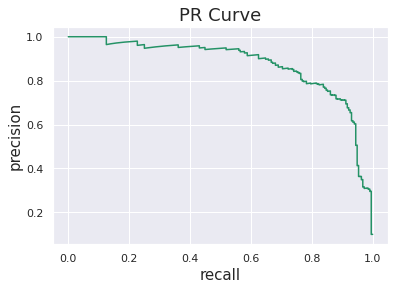

In [29]:
sns.set(palette='summer')

plt.plot(recall, precision)
plt.xlabel('recall', fontsize=15)
plt.ylabel('precision', fontsize=15)
plt.title("PR Curve", fontsize=18)
plt.show()